In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from scipy import stats
import pingouin as pg
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os

cwd = os.getcwd()

fnames = [
    'data/LEISURE_DEMO_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_CANTAB_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_SART_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_rsEEG_EC_T1_T2_T3_CONCAT.xlsx'
]

df = pd.DataFrame()
for i, fname in enumerate(fnames):
    df_t = pd.read_excel(os.path.join(cwd, fname))
    df_t.columns = df_t.columns.str.replace(" ", "_")
    df_t.columns = df_t.columns.str.replace("(", "_")
    df_t.columns = df_t.columns.str.replace(")", "_")
    df_t.columns = df_t.columns.str.replace("-", "_")
    print(df_t.columns)
    if i == 0:
        df = df_t.copy()
    else:
        df = df.merge(df_t, on=['subject', 'tp'], how='outer')

Index(['subject', 'tp', 'dob', 'age', 'gender_f', 'handedness_r', 'education',
       'EEG_date', 'group_life'],
      dtype='object')
Index(['subject', 'tp', 'DMSCC', 'DMSL0SD', 'DMSL12SD', 'DMSL4SD', 'DMSLADSD',
       'DMSLSD', 'DMSLSSD', 'DMSMDL',
       ...
       'SWMSZScore', 'SWMS6', 'SWMTE', 'SWMTE4', 'SWMTE6', 'SWMTE8', 'SWMWE',
       'SWMWE4', 'SWMWE6', 'SWMWE8'],
      dtype='object', length=149)
Index(['subject', 'tp', 'total_go', 'total_no_go', 'correct_go',
       'correct_no_go', 'incorrect_go', 'incorrect_no_go',
       'average_rt_correct_go', 'average_rt_incorrect_no_go',
       'sd_rt_correct_go', 'sd_rt_incorrect_no_go', 'median_rt_correct_go',
       'median_rt_incorrect_no_go', 'minimum_rt_correct_go',
       'minimum_rt_incorrect_no_go', 'maximum_rt_correct_go',
       'maximum_rt_incorrect_no_go', 'rts_correct_go', 'rts_incorrect_no_go',
       'hr', 'far', 'adj_hr', 'adj_far', 'z_adj_hr', 'z_adj_far', 'd_prime',
       'criterion'],
      dtype='object')
Inde

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     correct_go
No. Observations:     238         Method:                 REML      
No. Groups:           87          Scale:                  3.1769    
Min. group size:      2           Log-Likelihood:         -603.9317 
Max. group size:      3           Converged:              Yes       
Mean group size:      2.7                                           
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             481.406    2.638 182.502 0.000 476.236 486.576
tp[T.2]                -1.066    0.741  -1.438 0.150  -2.519   0.387
tp[T.3]                -0.416    0.453  -0.919 0.358  -1.304   0.472
age_bas                -0.049    0.033  -1.476 0.140  -0.114   0.016
education               0.019    0.066   0.283 0.7

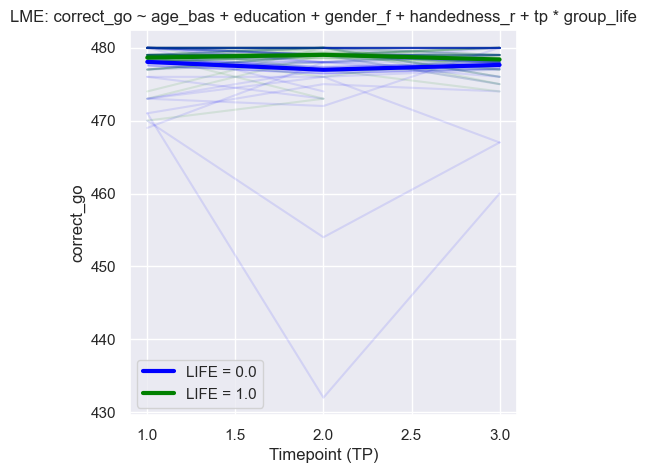

In [9]:
dv = 'correct_go'

# Prepare the data
df_lme = df[['subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]

df_lme = df_lme.sort_values(by=['subject', 'tp'])

# Add baseline age for interpretation
df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')

# Drop rows with missing values and keep only subjects with multiple timepoints
df_lme = df_lme.dropna()
df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

# Convert TP to a categorical variable
df_lme['tp'] = df_lme['tp'].astype('category')

# Mixed-effects model with TP as a categorical predictor
import statsmodels.formula.api as smf

formula = f"{dv} ~ age_bas + education + gender_f + handedness_r + tp * group_life"
model = smf.mixedlm(formula, data=df_lme, groups='subject', re_formula="~tp")
results = model.fit()

print(results.summary())

### plotting

sns.set(context='notebook', style='darkgrid')

# Add predictions to the DataFrame
df_lme['predicted'] = results.predict(df_lme)

# Plot settings
plt.figure(figsize=(5, 5))

# Define colors for groups
colors = {'0.0': 'blue', '1.0': 'green'} 

# Spaghetti plot: Individual trajectories, colored by group
for subject, group in df_lme.groupby('subject'):
    group_color = colors[str(group['group_life'].iloc[0])]  # Get group color
    plt.plot(
        group['tp'], group[dv],
        alpha=0.1, color=group_color, label='_nolegend_'
    )

# Aggregate predicted values for each group and timepoint
grouped = df_lme.groupby(['tp', 'group_life']).agg(
    predicted_mean=('predicted', 'mean'),
    predicted_std=('predicted', 'std')
).reset_index()

# Plot thicker model-predicted lines for each group
for i, group in enumerate(grouped['group_life'].unique()):
    group_data = grouped[grouped['group_life'] == group]
    plt.plot(
        group_data['tp'],
        group_data['predicted_mean'],
        label=f'LIFE = {group}',
        linewidth=3,
        color=colors[str(group)]
    )
    # Optionally add shaded area for standard deviation
    plt.fill_between(
        group_data['tp'],
        group_data['predicted_mean'] - group_data['predicted_std'],
        group_data['predicted_mean'] + group_data['predicted_std'],
        alpha=0.2,
        color=colors[str(group)]
    )

# Plot formatting
plt.title(f'LME: {formula}')
plt.xlabel('Timepoint (TP)')
plt.ylabel(dv)
plt.legend(loc='best')
plt.grid(True)
plt.show()

/Users/aliciacampbell/anaconda3/envs/datascience2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aliciacampbell/anaconda3/envs/datascience2/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent_fc
No. Observations:   239      Method:              REML       
No. Groups:         87       Scale:               0.0225     
Min. group size:    2        Log-Likelihood:      11.3348    
Max. group size:    3        Converged:           Yes        
Mean group size:    2.7                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.416    0.239  5.930 0.000  0.948  1.884
age_bas            -0.006    0.003 -1.967 0.049 -0.012 -0.000
education          -0.005    0.006 -0.822 0.411 -0.017  0.007
gender_f           -0.033    0.061 -0.531 0.595 -0.153  0.088
handedness_r       -0.044    0.075 -0.582 0.561 -0.191  0.104
time                0.052    0.048  1.064 0.288 -0.043  0.146
group_life          

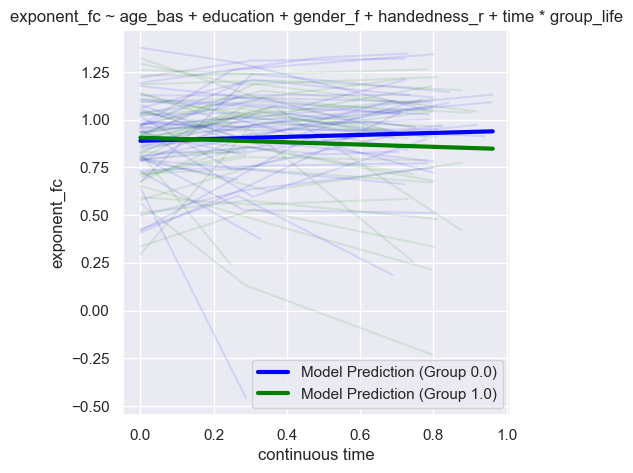

In [4]:
dv = 'exponent_fc'

df_lme = df[[f'subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]

df_lme = df_lme.sort_values(by=['subject', 'tp'])
df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')

df_lme = df_lme.dropna()

df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

import statsmodels.formula.api as smf

formula = f"{dv} ~ age_bas + education + gender_f + handedness_r + time * group_life"
model = smf.mixedlm(formula, data=df_lme, groups='subject', re_formula='~time')
results = model.fit()
print(results.summary())

### plotting

sns.set(context='notebook', style='darkgrid')

# Add smoother group-level predictions
time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
predictions = []
for group_life in df_lme['group_life'].unique():
    temp_df = pd.DataFrame({
        'time': time_grid,
        'group_life': group_life,
        'age_bas': df_lme['age_bas'].mean(),
        'education': df_lme['education'].mean(),
        'gender_f': df_lme['gender_f'].mean(),
        'handedness_r': df_lme['handedness_r'].mean()
    })
    temp_df['predicted'] = results.predict(temp_df)
    predictions.append(temp_df)
predictions = pd.concat(predictions)

# Plot settings
plt.figure(figsize=(5, 5))

# Define colors for groups
colors = {'0.0': 'blue', '1.0': 'green'} 

# Individual trajectories, grouped and smoothed
for subject, group in df_lme.groupby('subject'):
    group_color = colors[str(group['group_life'].iloc[0])]
    plt.plot(group['time'], group[dv], alpha=0.1, color=group_color, label='_nolegend_')

# Plot model predictions
for group_life in predictions['group_life'].unique():
    group_data = predictions[predictions['group_life'] == group_life]
    plt.plot(group_data['time'], group_data['predicted'],
             label=f'Model Prediction (Group {group_life})', linewidth=3, color=colors[str(group_life)])

plt.title(formula)
plt.xlabel('continuous time')
plt.ylabel(dv)
plt.legend(loc='best')
plt.grid(True)
plt.show()